In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quantstats as qs
import copy
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from datetime import datetime, timedelta
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA, plotting
from pypfopt import hierarchical_portfolio
from pypfopt import plotting
from metrics import *


DATA_DIR = (os.getcwd() + "/data/")
PREDICTION_DIR = (os.getcwd() + "/predictions_new/")
start_date = '2014-01-01'
end_date = "2019-11-30"
# Get fundamental data for each stock in the ticker and append to the dataframe


def get_all_symbols():
    return [v.strip('.csv') for v in os.listdir(DATA_DIR)]


def get_current_predictions():
    return [v.strip('_predictions.csv') for v in os.listdir(PREDICTION_DIR)]


tickers = get_all_symbols()
predicted_tickers = get_current_predictions()

sample_index = pd.read_csv(DATA_DIR + 'AAPL.csv',
                           index_col='Date', parse_dates=True)
mask = (sample_index.index >= start_date) & (sample_index.index <= end_date)
sample_index = sample_index.loc[mask]


In [2]:
def get_top_n_tickers(year, month, n):
    # print("Getting top n tickers for year: " + str(year) + " month: " + str(month))
    results = []
    for ticker in get_current_predictions():
        df = pd.read_csv(PREDICTION_DIR + ticker +
                         '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (df.index.year == year) & (df.index.month == month)
        df = df.loc[mask]
        # print(ticker, df['Next Month Returns Predictions'][0])
        results.append((ticker, df['Next Month Returns Predictions'][0]))

    # print(results)
    results.sort(key=lambda x: x[1], reverse=True)
    tickers = [i[0] for i in results[:n]]
    pred_vector = [i[1] for i in results[:n]]
    # print(pred_vector)
    # print(year, month)
    return tickers, pred_vector


def get_close_prices(year, month, d, tickers):
    df = pd.DataFrame()
    days = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=days)
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        mask = (data.index >= target_date) & (
            data.index <= datetime(year, month, 1))
        data = data.loc[mask]
        df[ticker] = data['Close']
        df.index = data.index

    return df


def generate_predicted_historical_returns(year, month, d, tickers):
    d = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=d)
    df = pd.DataFrame()
    for ticker in tickers:
        prediction = pd.read_csv(
            PREDICTION_DIR + ticker + '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (prediction.index >= target_date) & (
            prediction.index <= datetime(year, month, 1))
        prediction = prediction.loc[mask]
        df[ticker] = prediction['Next Month Returns Predictions']
        df.index = prediction.index
    return df


def get_top_n_tickers_combined(start_year, start_month, end_year, end_month, n):
    output = []
    pred_vectors = []
    curr_year, curr_month = start_year, start_month
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, n)
        output.append(tickers)
        pred_vectors.append(pred_vector)

        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
    return output, pred_vectors


def generate_close_data(tickers, month, year):
    df = pd.DataFrame()
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        data = data.loc[data.index.month == month]
        data = data.loc[data.index.year == year]
        df[ticker] = data['Close']
        df.index = data.index
    return df


def generate_all_close_data(tickers, start_year, start_month, end_year, end_month):
    output = pd.DataFrame()
    curr_year, curr_month = start_year, start_month
    curr_idx = 0
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        data = generate_close_data(tickers[curr_idx], curr_month, curr_year)
        output = pd.concat([output, data], axis=0, join='outer')
        output = output.reset_index(drop=True)
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
        curr_idx += 1

    output.index = sample_index.index
    return output


In [27]:
def generate_hrp_models(start_month, start_year, end_month, end_year, d, n):

    curr_year, curr_month = start_year, start_month
    dfs = {
        "d": [],
        "dfs": []
    }
    curr_max = 0
    curr_model = None
    for d in range(1, 4):
        df = {
            'sharpes': [],
            'expected_return': [],
            'annual_volatility': [],
            'num_stocks': [],
            'weights': []
        }
    # while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        for i in range(25, 275, 25):
            tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, i)
            close_data = get_close_prices(curr_year, curr_month, d, tickers)
            predicted_returns = generate_predicted_historical_returns(
                curr_year, curr_month, d, tickers)
            rets_old = expected_returns.returns_from_prices(close_data)

            hrp = hierarchical_portfolio.HRPOpt(rets_old)
            # hrp.add_objective(objective_functions.L2_reg, gamma=0.1)
            raw_weights = hrp.optimize()
            cleaned_weights = hrp.clean_weights()
            hrp.portfolio_performance(verbose=False)

            ex_return = hrp.portfolio_performance()[0]
            df['expected_return'].append(ex_return)
            df['num_stocks'].append(i)
            df['annual_volatility'].append(hrp.portfolio_performance()[1])
            df['sharpe  s'].append(hrp.portfolio_performance()[2])
            df['weights'].append(cleaned_weights)
            
            if hrp.portfolio_performance()[2] > curr_max:
                curr_max = hrp.portfolio_performance()[2]
                curr_model = hrp
        # print(ef.portfolio_performance()[0]) # sharpe ratio
        dfs["d"].append(d)
        dfs['dfs'].append(df)

    # Plot Graph
    # plt.plot(df['num_stocks'], df['sharpes'])
    # print(dfs)
    return dfs, curr_model


In [28]:
results, best_model = generate_hrp_models(1, 2014, 11, 2019, 1, 25)

C:\Users\yinki\AppData\Local\Temp\ipykernel_19488\4008166749.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ticker] = data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_19488\4008166749.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ticker] = data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_19488\4008166749.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

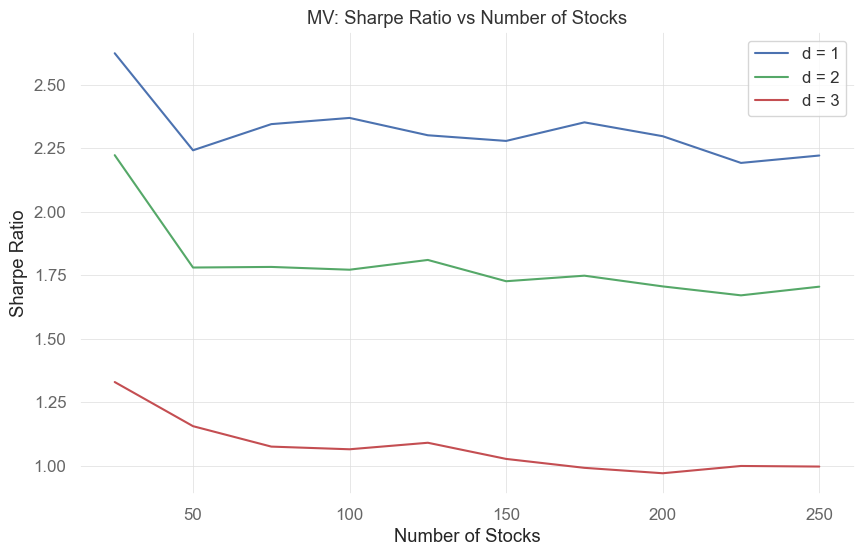

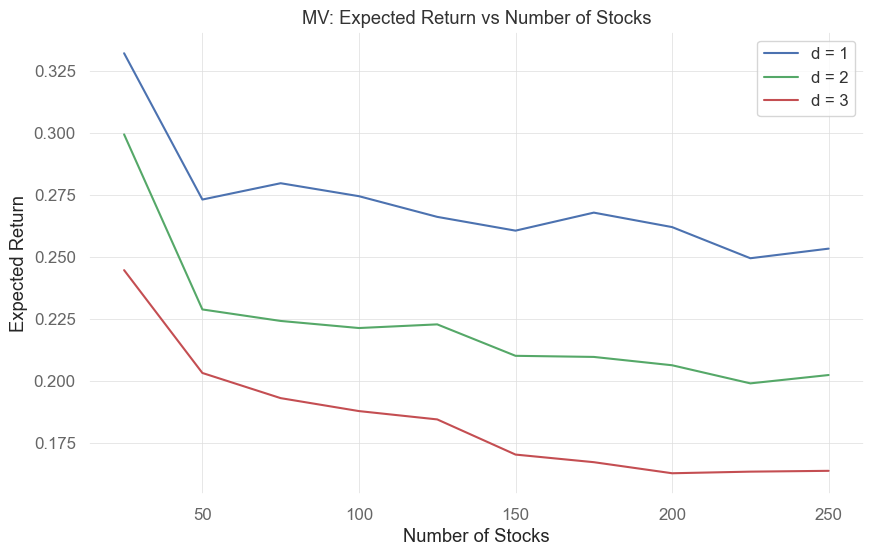

In [29]:
# Plot Graph results
# print(results)
# Make plot grid 2x2
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
d = [1, 2, 3]
for i, result in enumerate(results['dfs']):
    # print(i, result)
    plt.plot(result['num_stocks'], result['sharpes'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Sharpe Ratio')
    # plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Sharpe Ratio vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()

for i, result in enumerate(results['dfs']):
    # print(i, result)
    plt.plot(result['num_stocks'], result['expected_return'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Expected Return')
    # plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Expected Return vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()


Expected annual return: 33.2%
Annual volatility: 11.9%
Sharpe Ratio: 2.62
Performance of best portfolio: (0.3319550055725878, 0.11884792050573212, 2.6248251062797685)
Best Portfolio Weights: OrderedDict([('WAT', 0.02962), ('HSIC', 0.07772), ('APA', 0.05332), ('ECL', 0.0614), ('AOS', 0.02075), ('FAST', 0.03876), ('C', 0.02997), ('RCL', 0.0326), ('URI', 0.0091), ('PNR', 0.0262), ('BBY', 0.01478), ('FCX', 0.01886), ('GILD', 0.01526), ('TSN', 0.05379), ('VLO', 0.02035), ('SWK', 0.04948), ('SHW', 0.02522), ('MCK', 0.06726), ('EFX', 0.05786), ('NEE', 0.10065), ('VMC', 0.01213), ('RJF', 0.0196), ('IDXX', 0.06347), ('VFC', 0.0688), ('CSGP', 0.03306)])


<AxesSubplot: >

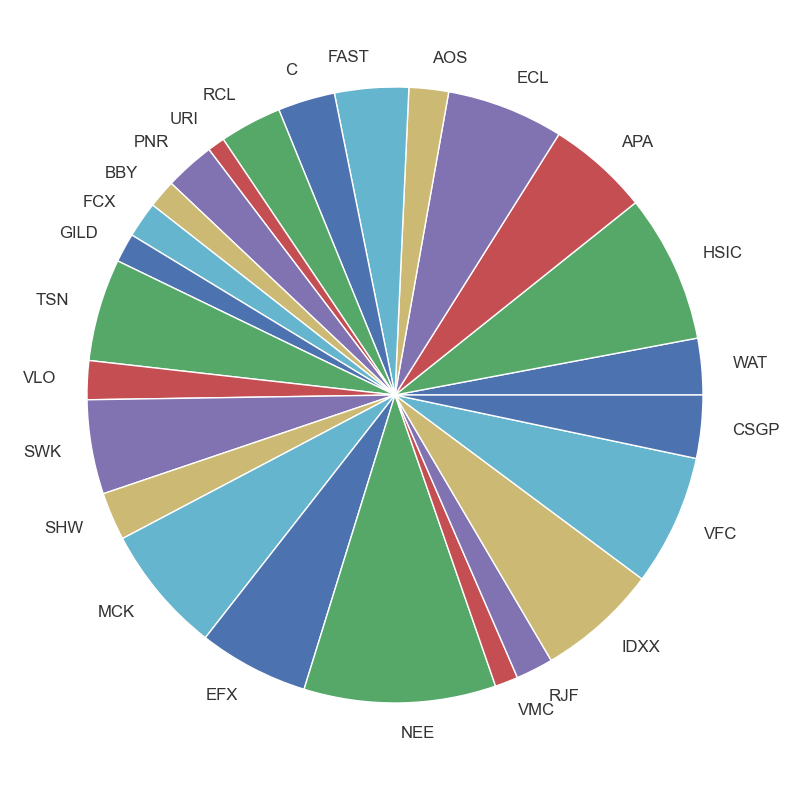

In [40]:
# Get best Portfolio based on sharpe ratio
# print(results)
print(f"Performance of best portfolio: {best_model.portfolio_performance(verbose=True)}")
print(f"Best Portfolio Weights: {best_model.clean_weights()}")

# Plotting
pd.Series(best_model.clean_weights()).plot.pie(figsize=(10, 10))



In [3]:
start_date = '2010-01-01'
end_date = "2019-11-30"

sample_index = pd.read_csv(DATA_DIR + 'AAPL.csv', index_col='Date', parse_dates=True)
mask = (sample_index.index >= start_date) & (sample_index.index <= end_date)
sample_index = sample_index.loc[mask]

In [8]:
def generate_close_data(tickers, month, year):
    df = pd.DataFrame()
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        data = data.loc[data.index.month == month]
        data = data.loc[data.index.year == year]
        df[ticker] = data['Close']
        df.index = data.index
    return df

def generate_past_close_data(tickers, month, year):
    df = pd.DataFrame()
    
    data = pd.read_csv(os.getcwd() + '\processed_data\close_data_3year.csv', index_col='Date', parse_dates=True)
    data = data[tickers]
    mask = (data.index.month <= month) & (data.index.year <= year)
    data = data.loc[mask]
    return data


def generate_all_close_data(tickers, start_year, start_month, end_year, end_month):
    output = pd.DataFrame()
    curr_year, curr_month = start_year, start_month
    curr_idx = 0
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        data = generate_close_data(tickers[curr_idx], curr_month, curr_year)
        output = pd.concat([output, data], axis=0, join='outer')
        output = output.reset_index(drop=True)
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
        curr_idx += 1
        
    output.index = sample_index.index
    return output

generate_past_close_data(['AAPL', 'MSFT', 'AMZN'], 11, 2019)
mu = expected_returns.returns_from_prices(generate_past_close_data(['AAPL', 'MSFT', 'AMZN'], 11, 2019))
hrp = hierarchical_portfolio.HRPOpt(mu)
raw_weights = hrp.optimize()
cleaned_weights = hrp.clean_weights()
hrp.portfolio_performance(verbose=True)

Expected annual return: 25.7%
Annual volatility: 20.8%
Sharpe Ratio: 1.14


(0.25746905270774595, 0.20795540704820928, 1.141922953956637)

In [10]:
import pandas as pd
import numpy as np
import pypfopt as popt

# Load stock data
stock_data = pd.read_csv(os.getcwd() + '\processed_data\close_data_3year.csv')
result, predicted_vectors = get_top_n_tickers_combined(2014, 1, 2019, 11, 25)
#output = generate_all_close_data(result, 2014, 1, 2019, 11)

# Convert dates to DateTime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set start and end dates for rebalancing
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2019-11-30')
portfolio_weights = pd.DataFrame(columns=['Date', 'Ticker', 'Weight'])

# Define function to rebalance portfolio
def rebalance_portfolio(stock_tickers, current_date):
    global portfolio_weights
    # Filter stock data based on input tickers and current date
    #relevant_data = stock_data[stock_tickers]
    #relevant_data = stock_data[(stock_data['Date'] <= current_date)]

    # Calculate expected returns and covariances
    #tickers, pred_vector = get_top_n_tickers(current_date.year, current_date.month, 25)
    output = generate_past_close_data(stock_tickers, current_date.month, current_date.year)
    mu = expected_returns.returns_from_prices(output)
    hrp = hierarchical_portfolio.HRPOpt(mu)
    raw_weights = hrp.optimize()
    cleaned_weights = hrp.clean_weights()
    #hrp.portfolio_performance(verbose=True)
    #print(cleaned_weights)
    # Optimize portfolio
    #optimized_portfolio = objective.optimize(expected_returns, covariance_matrix)

    # Rebalance portfolio based on optimized weights
    for stock_index, stock_ticker in enumerate(stock_tickers):
        # Add optimized weights to portfolio weights DataFrame
        weight = cleaned_weights[stock_ticker]
        new_row = pd.DataFrame({'Date': current_date, 'Ticker': stock_ticker, 'Weight': weight},  index=[0])
        new_result = pd.concat([portfolio_weights, new_row], axis=0, ignore_index=True)
        portfolio_weights = new_result
        #print(portfolio_weights)
        #portfolio_weights.loc[(portfolio_weights['Ticker'] == stock_ticker) & (portfolio_weights['Date'] == current_date)] 
        #= cleaned_weights[stock_index]
        #stock_data.loc[(stock_data['Ticker'] == stock_ticker) & (stock_data['Date'] == current_date), 'Weight'] = optimized_portfolio.clean_weights()[stock_index]

# Rebalance portfolio monthly from start to end date
current_date = start_date
while current_date <= end_date:
    # Get input vector of stock tickers for the current month
    stock_tickers, pred_vector = get_top_n_tickers(current_date.year, current_date.month, 25)
    #print(stock_tickers)

    # Rebalance portfolio using the input tickers
    rebalance_portfolio(stock_tickers, current_date)

    # Increment the date to the next month
    current_date = current_date + pd.DateOffset(months=1)

In [11]:
# Pivot the DataFrame to wide form
wide_df = portfolio_weights.pivot(index='Date', columns='Ticker', values='Weight')

# Reset the index to make 'Date' a regular column
wide_df = wide_df.reset_index()
wide_df.fillna(0, inplace=True)
wide_df = wide_df.set_index('Date')
# Display the result
(wide_df)

Ticker,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEP,AES,...,WHR,WM,WMB,WMT,WRB,WST,WY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
2014-02-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
2014-03-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.10726,0.0
2014-04-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
2014-05-01,0.0,0.0,0.00000,0.00831,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.06133,0.02622,0.14734,0.00000,...,0.0,0.0,0.00000,0.09314,0.0,0.0,0.00000,0.0,0.00000,0.0
2019-08-01,0.0,0.0,0.00000,0.02025,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0
2019-09-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.01656,0.00000,0.05324,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.03133,0.0


In [14]:
returns_data = pd.read_csv(os.getcwd() + '\\processed_data\\returns_data.csv', index_col='Date for next')
stocks = list(wide_df.columns)
print(stocks)
returns_data = returns_data[stocks]
returns_data

['AAPL', 'ABT', 'ACGL', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEP', 'AES', 'AFL', 'AIG', 'AJG', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'AVB', 'AVY', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK', 'BKR', 'BMY', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CCI', 'CCL', 'CDNS', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMA', 'CMI', 'CMS', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH', 'CVS', 'CVX', 'D', 'DD', 'DE', 'DGX', 'DHI', 'DHR', 'DIS', 'DLTR', 'DOV', 'DRI', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EG', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQR', 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDS', 'FDX', 'FI', 'FICO', 'FITB', 'FMC', 'GD', 'GE', 'GEN', 'GILD', 'GLW', 'GWW', 'HAL', 'HAS', 'HBAN', 'HD', 'HES', 'HIG', 'HOLX', 'HON', 'HPQ', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM

,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEP,AES,...,WHR,WM,WMB,WMT,WRB,WST,WY,YUM,ZBRA,ZION
Date for next,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.008902,0.003666,0.014618,0.054597,0.056201,0.078261,0.009748,0.112044,-0.006800,-0.004118,...,0.026840,-0.017732,0.095116,-0.028638,-0.009134,-0.017228,0.047793,-0.026648,0.043210,0.021480
2014-02-01,-0.107697,-0.043569,-0.098509,-0.011523,-0.052229,-0.090323,-0.051980,0.018482,0.044288,-0.031013,...,-0.150198,-0.068866,0.049780,-0.050959,-0.106707,-0.032817,-0.053532,-0.111890,0.016272,-0.040387
2014-03-01,0.051219,0.085106,0.042929,0.159486,0.052828,0.028369,0.015405,0.024000,0.028478,-0.029161,...,0.084996,-0.006702,0.020005,0.000268,0.063983,-0.039410,-0.012383,0.103202,0.255277,0.085217
2014-04-01,0.019953,-0.031926,0.025303,-0.042110,0.045651,0.068719,-0.006686,-0.062881,0.009163,0.046154,...,0.033396,0.013735,-0.017433,0.023159,0.009214,-0.033567,-0.005422,0.017684,0.006088,-0.007051
2014-05-01,0.099396,0.005973,-0.003823,-0.061606,-0.034814,0.007836,0.009060,-0.023587,0.062179,0.011905,...,0.026228,0.056572,0.039182,0.042915,0.062950,-0.015210,0.017036,0.021223,0.000432,-0.066494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,0.130519,0.104689,0.076968,0.087671,0.168185,0.064718,0.032538,0.012367,0.021946,0.060759,...,0.239206,0.055053,0.062927,0.089215,0.059968,0.092059,0.155263,0.081290,0.221944,0.067564
2019-08-01,0.076394,0.035672,0.043420,0.014288,0.040666,0.006863,0.007198,-0.041314,-0.002273,0.001790,...,0.021916,0.014128,-0.121255,-0.000996,0.052480,0.096844,-0.035308,0.016716,0.006683,-0.019791
2019-09-01,-0.020184,-0.020436,0.020936,-0.048016,-0.064958,-0.073759,0.019937,-0.085484,0.038037,-0.086957,...,-0.043924,0.020085,-0.042208,0.035151,0.026805,0.059663,0.035419,0.037860,-0.027787,-0.088307


In [15]:
# Merge the returns and weights DataFrames on weights date and returns date for next column
wide_df.index = pd.to_datetime(wide_df.index)
returns_data.index = pd.to_datetime(returns_data.index)
merged_data = pd.concat([wide_df, returns_data], axis=1 ,keys=['Portfolio_Weights', 'Stock_Returns'])
merged_data.columns = [f'{col[0]}_{col[1]}' for col in merged_data.columns]
# Reset the index to have 'Date' as a regular column
merged_data = merged_data.reset_index()
merged_data = merged_data.rename(columns={'index': 'Date'})
merged_data = merged_data.set_index('Date')
merged_data



,Portfolio_Weights_AAPL,Portfolio_Weights_ABT,Portfolio_Weights_ACGL,Portfolio_Weights_ADBE,Portfolio_Weights_ADI,Portfolio_Weights_ADM,Portfolio_Weights_ADP,Portfolio_Weights_ADSK,Portfolio_Weights_AEP,Portfolio_Weights_AES,...,Stock_Returns_WHR,Stock_Returns_WM,Stock_Returns_WMB,Stock_Returns_WMT,Stock_Returns_WRB,Stock_Returns_WST,Stock_Returns_WY,Stock_Returns_YUM,Stock_Returns_ZBRA,Stock_Returns_ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.026840,-0.017732,0.095116,-0.028638,-0.009134,-0.017228,0.047793,-0.026648,0.043210,0.021480
2014-02-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,-0.150198,-0.068866,0.049780,-0.050959,-0.106707,-0.032817,-0.053532,-0.111890,0.016272,-0.040387
2014-03-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.084996,-0.006702,0.020005,0.000268,0.063983,-0.039410,-0.012383,0.103202,0.255277,0.085217
2014-04-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.033396,0.013735,-0.017433,0.023159,0.009214,-0.033567,-0.005422,0.017684,0.006088,-0.007051
2014-05-01,0.0,0.0,0.00000,0.00831,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.026228,0.056572,0.039182,0.042915,0.062950,-0.015210,0.017036,0.021223,0.000432,-0.066494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.06133,0.02622,0.14734,0.00000,...,0.239206,0.055053,0.062927,0.089215,0.059968,0.092059,0.155263,0.081290,0.221944,0.067564
2019-08-01,0.0,0.0,0.00000,0.02025,0.0,0.0,0.00000,0.00000,0.00000,0.00000,...,0.021916,0.014128,-0.121255,-0.000996,0.052480,0.096844,-0.035308,0.016716,0.006683,-0.019791
2019-09-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.01656,0.00000,0.05324,...,-0.043924,0.020085,-0.042208,0.035151,0.026805,0.059663,0.035419,0.037860,-0.027787,-0.088307


In [16]:
for ticker in wide_df.columns:  # Exclude 'Date' column
    merged_data[f'{ticker}_Weighted_Return'] = merged_data['Portfolio_Weights_' + ticker] * merged_data['Stock_Returns_' + ticker]
    
merged_data['Portfolio_Return'] = merged_data.filter(like='_Weighted_Return').sum(axis=1)
portfolio = merged_data[['Portfolio_Return']]

C:\Users\yinki\AppData\Local\Temp\ipykernel_22928\3446837121.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{ticker}_Weighted_Return'] = merged_data['Portfolio_Weights_' + ticker] * merged_data['Stock_Returns_' + ticker]
C:\Users\yinki\AppData\Local\Temp\ipykernel_22928\3446837121.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{ticker}_Weighted_Return'] = merged_data['Portfolio_Weights_' + ticker] * merged_data['Stock_Returns_' + ticker]
C:\Users\yinki\AppData\Local\Temp\ipykernel_22928\3446

Optimized Portfolio:
Date
2014-01-31    0.007935
2014-02-28   -0.046589
2014-03-31    0.070936
2014-04-30    0.002465
2014-05-31    0.012196
                ...   
2019-07-31    0.057062
2019-08-31    0.005600
2019-09-30   -0.017555
2019-10-31   -0.000290
2019-11-30   -0.000959
Freq: M, Name: Portfolio_Return, Length: 71, dtype: float64

S&P 500 Benchmark:
Date
2014-01-31    0.017258
2014-02-28   -0.049176
2014-03-31    0.059613
2014-04-30    0.021558
2014-05-31   -0.000976
                ...   
2019-07-31    0.080118
2019-08-31   -0.003633
2019-09-30   -0.016011
2019-10-31    0.011692
2019-11-30    0.043078
Freq: M, Name: Close, Length: 71, dtype: float64
1.0709825296049071


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-31   2014-01-31
End Period                 2019-11-30   2019-11-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          70.3%        118.75%
CAGR﹪                     6.5%         9.71%

Sharpe                     0.79         1.07
Prob. Sharpe Ratio         96.38%       99.32%
Smart Sharpe               0.64         0.87
Sortino                    1.21         1.84
Smart Sortino              0.98         1.5
Sortino/√2                 0.86         1.3
Smart Sortino/√2           0.69         1.06
Omega                      2.37         2.37

Max Drawdown               -14.17%      -19.83%
Longest DD Days            459          457
Volatility (ann.)          12.35%       13.22%
R^2                        0.74         0.74
Information Ratio          0.18         0.18
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-31,2019-01-31,2019-06-30,457,-19.829631,-10.597091
2,2015-07-31,2015-10-31,2016-03-31,245,-9.309285,-6.342325
3,2014-02-28,2014-02-28,2014-02-28,1,-4.658931,NaN
4,2016-10-31,2016-11-30,2016-11-30,31,-3.011704,-0.627335
5,2019-09-30,2019-11-30,2019-11-30,62,-1.878260,-1.784029


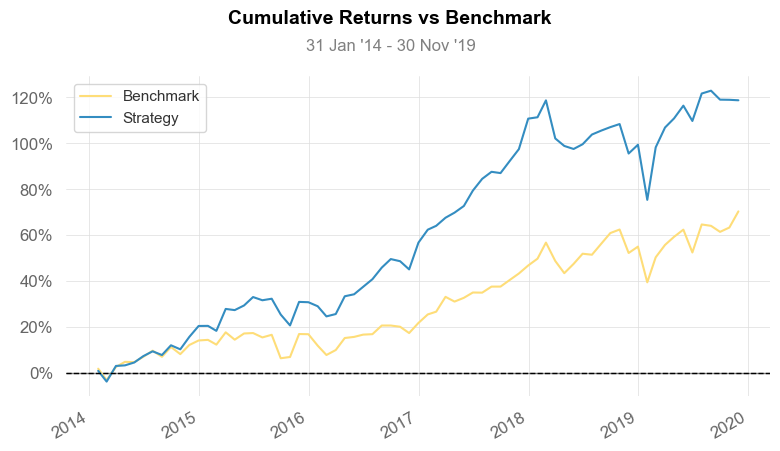

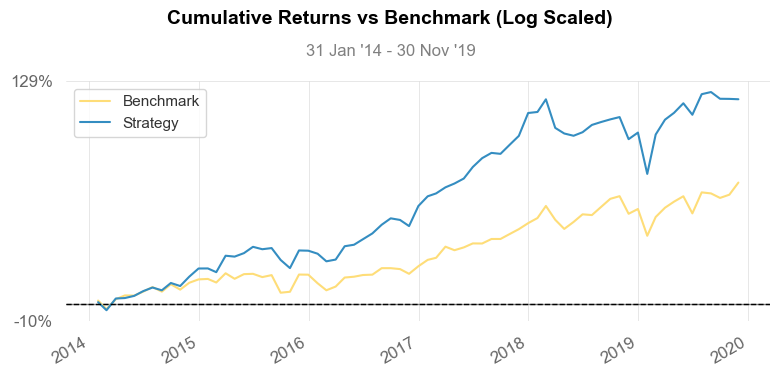

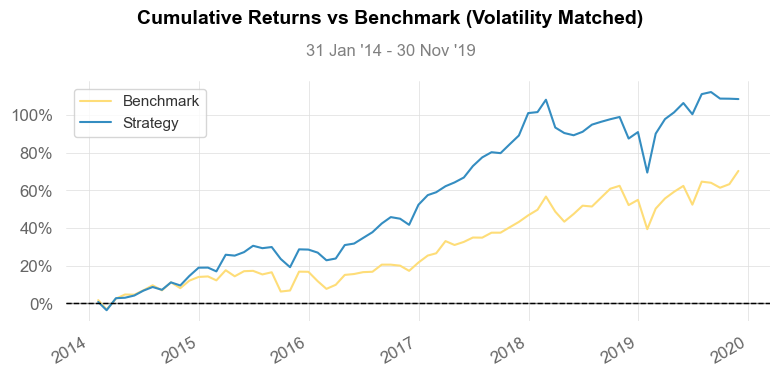

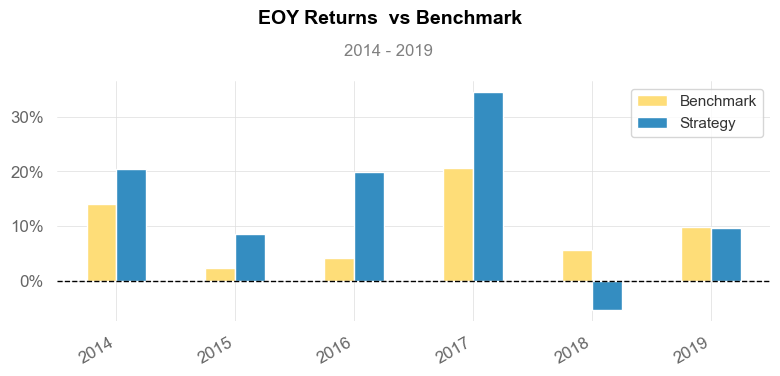

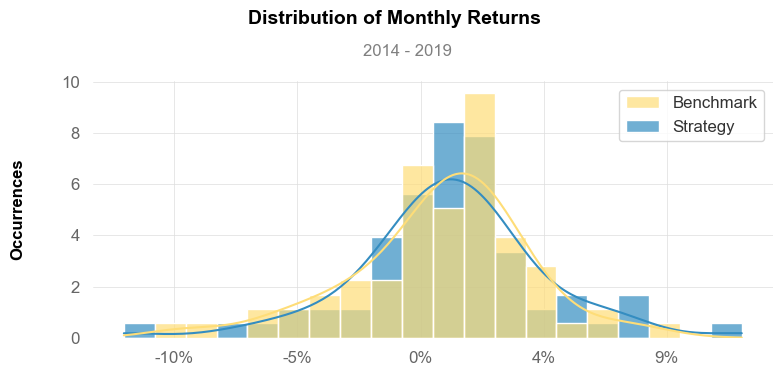

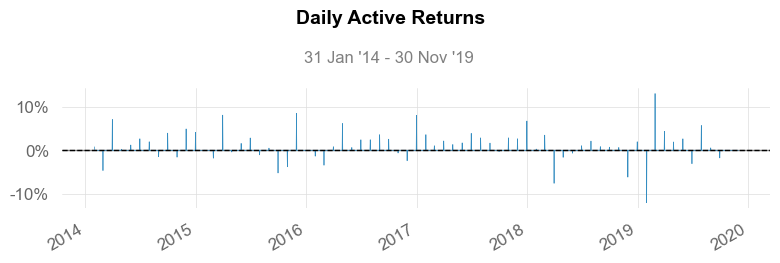

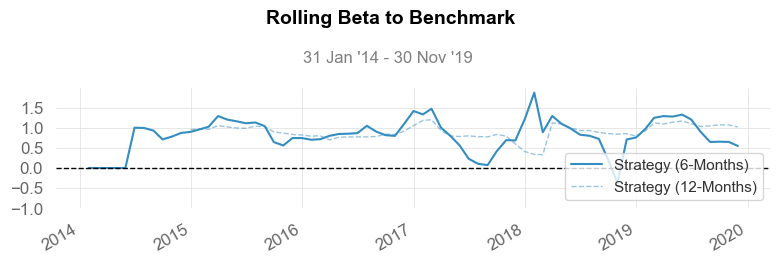

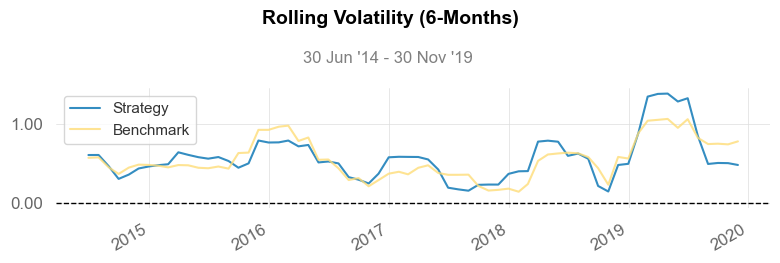

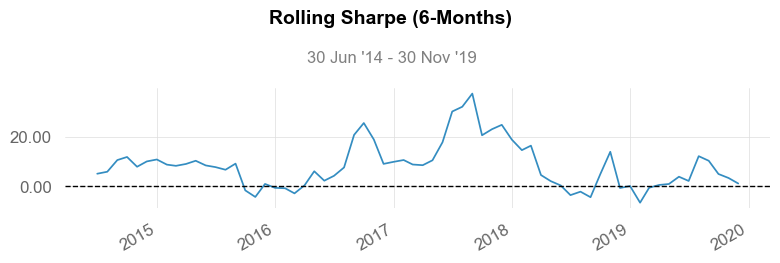

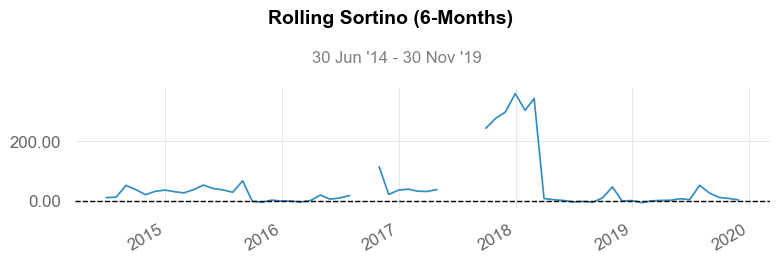

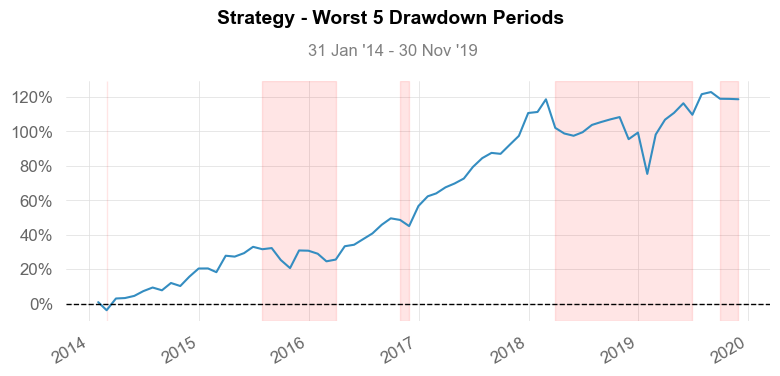

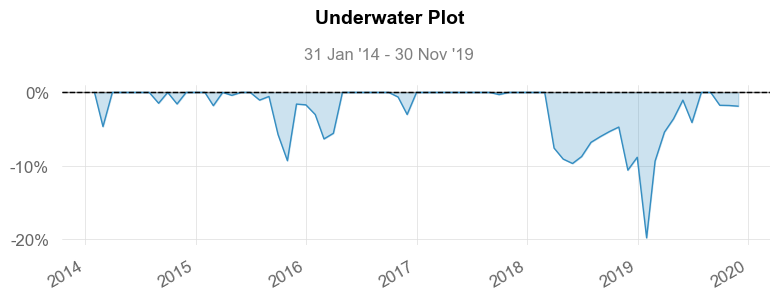

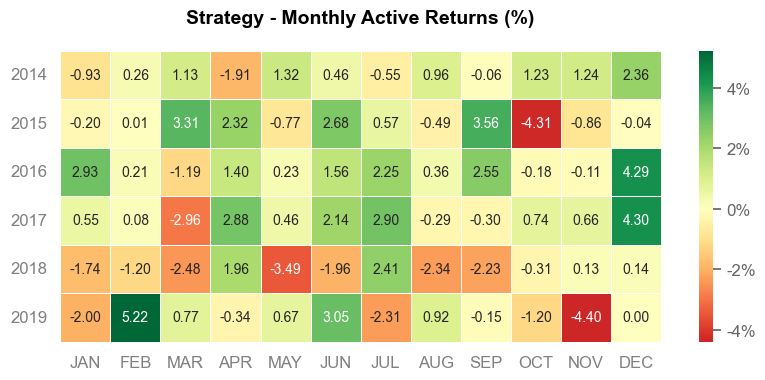

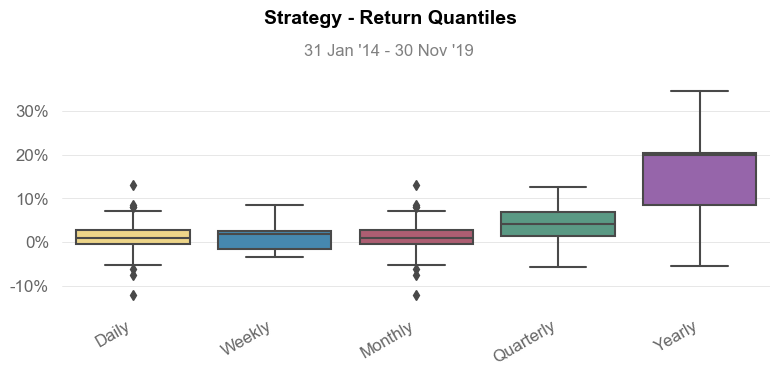

In [23]:
# Get SP500 Benchmark
import pyfolio as pf
qs.extend_pandas()
sp500 = pd.read_csv(DATA_DIR + 'GSPC.csv', index_col='Date', parse_dates=True)
mask = (sp500.index >= datetime(2013, 12, 1)) & (sp500.index <= datetime(2019, 11, 30))
sp500 = sp500.loc[mask]
sp500 = sp500['Close']
sp500 = sp500.resample('M').first().pct_change().dropna()  
optimized_portfolio = portfolio['Portfolio_Return']

portfolio.index = sp500.index
print("Optimized Portfolio:")
print(optimized_portfolio)

print("\nS&P 500 Benchmark:")
print(sp500)
print(qs.stats.sharpe(optimized_portfolio, periods=12))
report = qs.reports.full(optimized_portfolio , benchmark=sp500, periods_per_year=12)